In [7]:
import pandas as pd
import math

df = pd.read_csv("Test.csv")

df.head()

,Name
0,PRIYADHARSHINI S
1,PRIYANGA S
2,PRIYANKA R
3,RACHITHA S
4,RAJESH H


In [8]:
num_rows = len(df)
num_qubits = math.ceil(math.log2(num_rows))

print(f"Total rows: {num_rows}")
print(f"Qubits required: {num_qubits}")


Total rows: 66
Qubits required: 7


In [9]:
df = df.reset_index().rename(columns={"index": "RowIndex"})

df["BinaryIndex"] = df["RowIndex"].apply(
    lambda x: format(x, f"0{num_qubits}b")
)

df.head()


,RowIndex,Name,BinaryIndex
0,0,PRIYADHARSHINI S,0000000
1,1,PRIYANGA S,0000001
2,2,PRIYANKA R,0000010
3,3,RACHITHA S,0000011
4,4,RAJESH H,0000100


In [10]:
mapping = {
    row["BinaryIndex"]: row.drop(["RowIndex", "BinaryIndex"]).to_dict()
    for _, row in df.iterrows()
}

for k, v in list(mapping.items())[:5]:
    print(f"{k} -> {v}")


0000000 -> {'Name': 'PRIYADHARSHINI S'}
0000001 -> {'Name': 'PRIYANGA S'}
0000010 -> {'Name': 'PRIYANKA R'}
0000011 -> {'Name': 'RACHITHA S'}
0000100 -> {'Name': 'RAJESH H'}


In [11]:

search_column = "Name"      
search_value = "SASIKUMAR R"      


target_rows = df[df[search_column] == search_value]

if target_rows.empty:
    print(f"No match found for {search_value} in column {search_column}")
else:
    print(f" Match found:\n{target_rows}")

    # Get RowIndex and BinaryIndex of first match
    target_row = target_rows.iloc[0]
    target_binary = target_row["BinaryIndex"]

    print(f"\nTarget Binary Index: {target_binary}")
    print(f"Target Row Data: {target_row.to_dict()}")


 Match found:
    RowIndex         Name BinaryIndex
25        25  SASIKUMAR R     0011001

Target Binary Index: 0011001
Target Row Data: {'RowIndex': 25, 'Name': 'SASIKUMAR R', 'BinaryIndex': '0011001'}


In [18]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import MCXGate

# Oracle builder compatible with Qiskit v2.0.3
def build_oracle(target_binary: str) -> QuantumCircuit:
    num_qubits = len(target_binary)
    oracle = QuantumCircuit(num_qubits)

    # Flip bits where target is '0' (little-endian order handling)
    for i, bit in enumerate(reversed(target_binary)):
        if bit == '0':
            oracle.x(i)

    # Apply multi-controlled Z via MCX wrapped by H on target qubit
    oracle.h(num_qubits - 1)
    oracle.append(MCXGate(num_qubits - 1), list(range(num_qubits)))
    oracle.h(num_qubits - 1)

    # Undo the flips
    for i, bit in enumerate(reversed(target_binary)):
        if bit == '0':
            oracle.x(i)

    oracle.name = "Oracle"
    return oracle


In [19]:
from qiskit import QuantumCircuit

def build_diffuser(num_qubits: int) -> QuantumCircuit:
    diffuser = QuantumCircuit(num_qubits)

    # Inversion about the mean
    diffuser.h(range(num_qubits))
    diffuser.x(range(num_qubits))
    diffuser.h(num_qubits - 1)
    diffuser.mcx(list(range(num_qubits - 1)), num_qubits - 1)
    diffuser.h(num_qubits - 1)
    diffuser.x(range(num_qubits))
    diffuser.h(range(num_qubits))

    diffuser.name = "Diffuser"
    return diffuser


In [20]:
from qiskit import QuantumCircuit

def build_diffuser(num_qubits: int) -> QuantumCircuit:
    diffuser = QuantumCircuit(num_qubits)

    # Inversion about the mean
    diffuser.h(range(num_qubits))
    diffuser.x(range(num_qubits))
    diffuser.h(num_qubits - 1)
    diffuser.mcx(list(range(num_qubits - 1)), num_qubits - 1)
    diffuser.h(num_qubits - 1)
    diffuser.x(range(num_qubits))
    diffuser.h(range(num_qubits))

    diffuser.name = "Diffuser"
    return diffuser


Running Grover with 9 iterations


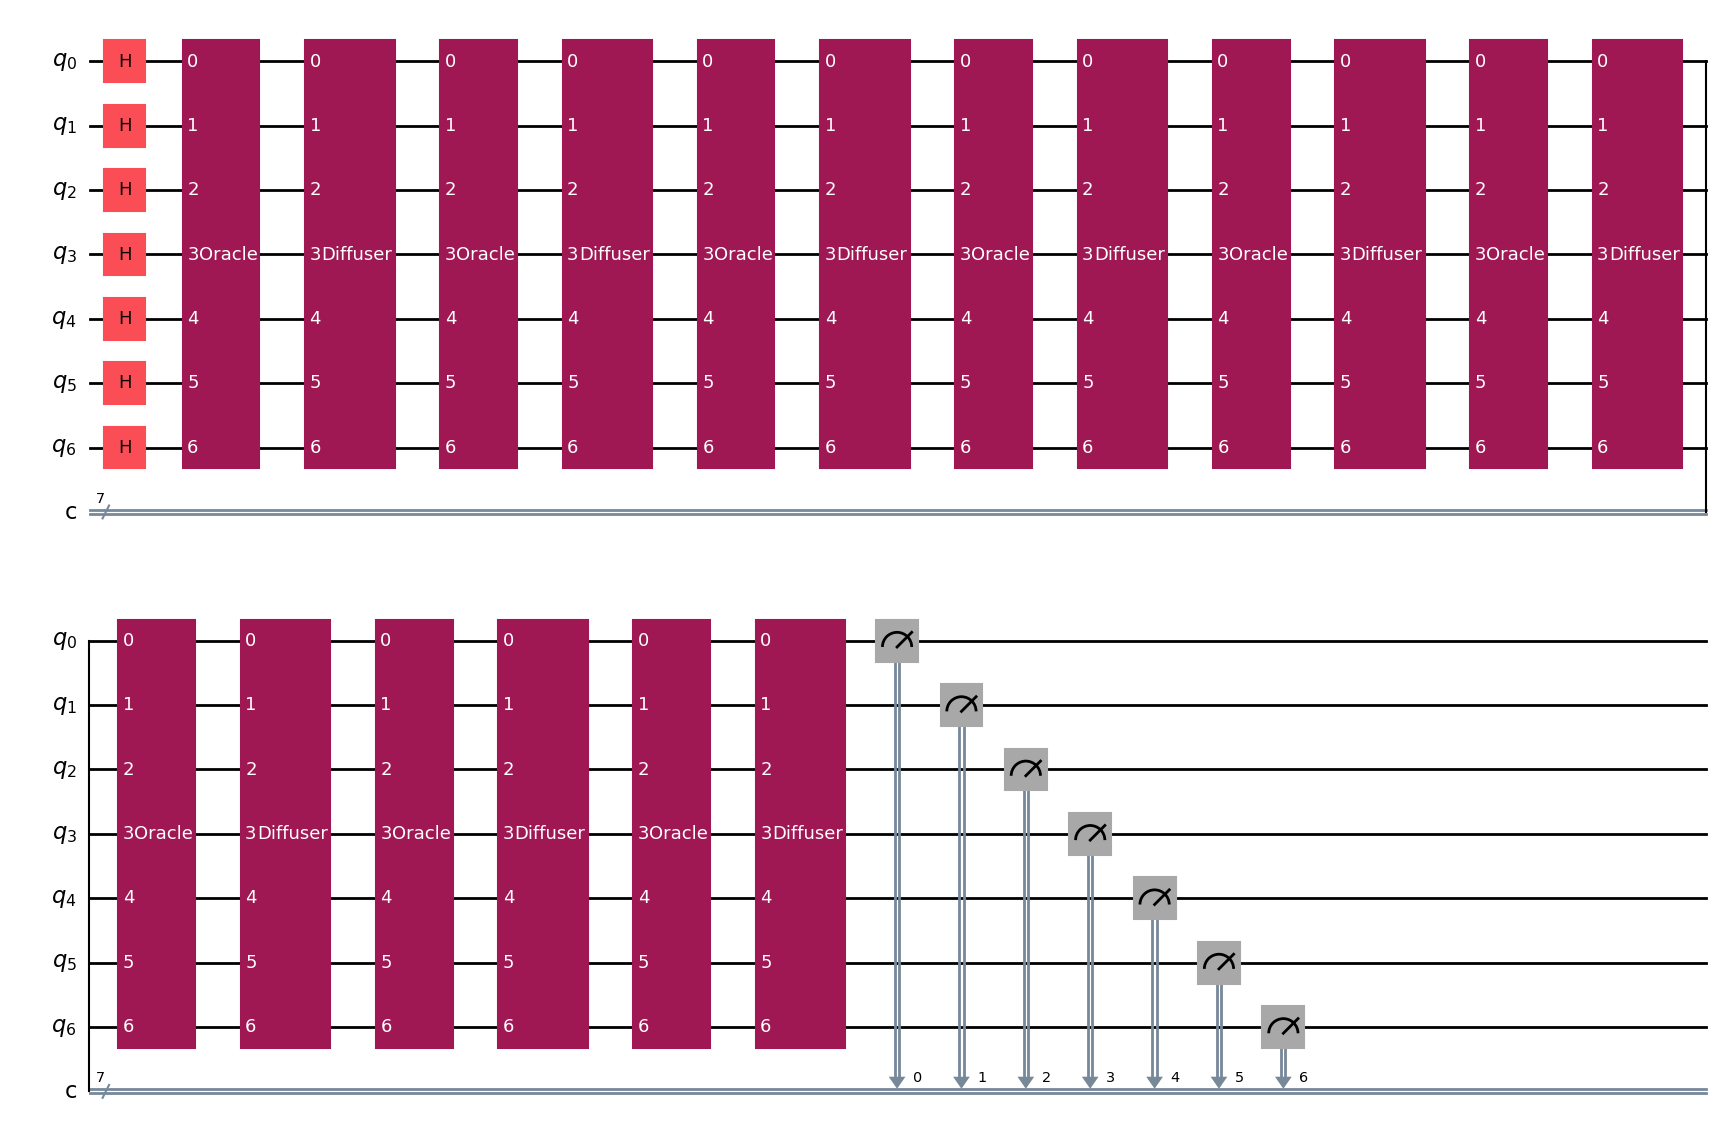

In [23]:
from qiskit_aer import Aer   # Aer is separate in Qiskit 2.x
from qiskit import transpile
from math import pi, sqrt

# Number of qubits (from your target_binary string)
num_qubits = len(target_binary)

# Build oracle and diffuser
oracle = build_oracle(target_binary)
diffuser = build_diffuser(num_qubits)

# Initialize Grover circuit with classical bits for measurement
grover = QuantumCircuit(num_qubits, num_qubits)

# 1. Superposition initialization
grover.h(range(num_qubits))

# 2. Determine number of iterations (~ π/4 * √N)
iterations = round(pi/4 * sqrt(2**num_qubits))
print(f"Running Grover with {iterations} iterations")

# 3. Apply Grover iterations: Oracle + Diffuser
for _ in range(iterations):
    grover.append(oracle, range(num_qubits))
    grover.append(diffuser, range(num_qubits))

# 4. Measurement
grover.measure(range(num_qubits), range(num_qubits))

# Visualize circuit
grover.draw("mpl")


Result counts: {'1001100': 1, '1111001': 1, '0010001': 1, '1101011': 1, '0101010': 1, '0100011': 2, '1010110': 1, '1011001': 1, '1000001': 1, '1001111': 1, '0000010': 1, '0110010': 2, '1100011': 1, '0110011': 1, '0011001': 1008}


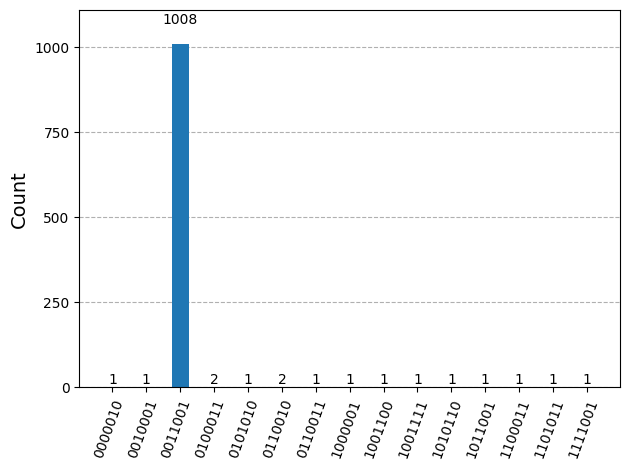

In [24]:
from qiskit.visualization import plot_histogram

# Run on Qiskit Aer simulator (Qiskit 2.x style)
sim = Aer.get_backend('qasm_simulator')
compiled = transpile(grover, sim)
result = sim.run(compiled, shots=1024).result()

# Get measurement results
counts = result.get_counts()
print("Result counts:", counts)

# Plot histogram of outcomes
plot_histogram(counts)


In [25]:
# === Step 10: Map Grover's Output to CSV Data ===

# Find the most frequent binary result
most_common_binary = max(counts, key=counts.get)
print(f"Most frequent measured binary index: {most_common_binary}")

# Map back to original row
row_data = mapping.get(most_common_binary, None)

if row_data:
    print("✅ Corresponding row found in CSV:")
    print(row_data)
else:
    print("❌ No matching row found in mapping.")


Most frequent measured binary index: 0011001
✅ Corresponding row found in CSV:
{'Name': 'SASIKUMAR R'}
